In [1]:
import datetime as DT
import matplotlib.pylab as plt
from numpy.linalg import norm
import numpy as  np
import skyfield.api as sfapi
from skyfield.api import wgs84,utc
import skyfield.sgp4lib as sgp4lib
import Geoidlib
from scipy.optimize import minimize_scalar
from skyfield.positionlib import ICRF
from skyfield.units import Distance
from skyfield.framelib import itrs
#%matplotlib widget
#%matplotlib qt4
#plt.rcParams['font.size']=26

In [2]:
def rotate (unitvec, yaw, pitch, roll, deg=False):
    def Rx (v,th):
        s=np.sin(th)
        c=np.cos(th)
        return np.matmul([[1,0,0],[0,c,-s],[0,s,c]],v)
    def Ry (v,th):
        s=np.sin(th)
        c=np.cos(th)
        return np.matmul([[c,0,s],[0,1,0],[-s,0,c]],v)
    def Rz (v,th):
        s=np.sin(th)
        c=np.cos(th)
        return np.matmul([[c,-s,0],[s,c,0],[0,0,1]],v)
    if deg :
        roll*=(np.pi/180)
        pitch*=(np.pi/180)
        yaw*=(np.pi/180)
    return Rz(Ry(Rx(unitvec,roll),pitch),yaw)

def xyz2radec(vector, deg=False, positivera=False):
    ra = np.arctan2(vector[1],vector[0])
    if positivera : 
        if ra <0 : ra+=2*np.pi
    dec = np.arcsin(vector[2]/np.sqrt(np.dot(vector,vector)))
    if deg :
        ra*=180./np.pi
        dec*=180./np.pi
    return [ra,dec]

def radec2xyz(ra,dec, deg=True):
    if deg:
        ra*=np.pi/180.
        dec*=np.pi/180.
    z=np.sin(dec)
    x=np.cos(ra)*np.cos(dec)
    y=np.sin(ra)*np.cos(dec)
    return [x,y,z]

        
def get_tle_dateDB (d):
    db=sqlite.connect('/Users/donal/mydocs/ODIN/Tle/odintletext.db')
    cur=db.cursor()
    sperday=24.*60*60
    doy=d-DT.datetime(d.year,1,1)
    datekey =((d.year-int(d.year/100)*100)*1000 + doy.days+doy.seconds/sperday)*100
    query="select tle1,tle2 from odintle where datekey between {} and {}"
    r=cur.execute(query.format(datekey,datekey+400)) #four day margin
    tle=r.fetchone()
    cur.close()
    db.close()
    return tle

def loadysb(d):
    ysb=[]
    with open('YBS.edb','r') as fb:
        for line in fb:
            if line[0] !='#' and len(line) >1 : 
                st=ephem.readdb(line)
                st.compute()
                ysb.append(st)
    return ysb

In [3]:

ts=sfapi.load.timescale()
tle=['1 99988U 22123A   22327.21800926  .00000000  00000-0  22763-3 0   159',
    '2 99988  97.6525 329.4315 0012466 240.1585 268.5406 14.92722274002766']
sfodin = sgp4lib.EarthSatellite(tle[0],tle[1])

In [4]:
def funpitch(pitch,t,th,pos,yaw,rotmatrix):
    #print(pitch*180/np.pi)
    FOV=rotate(np.array([1,0,0]),yaw,pitch,0,deg=False)
    FOV=np.matmul(rotmatrix,FOV)
    tp=findtangent(t,pos,FOV)
    return((tp.fun-th)**2)

def funheight (s,t,pos,FOV):
    newp = pos + s * FOV
    newp=ICRF(Distance(m=newp).au,t=t,center=399)
    return wgs84.subpoint(newp).elevation.m


def findtangent(t,pos,FOV):
    res=minimize_scalar(funheight,args=(t,pos,FOV),bracket=(1e5,3e5))
    return res

def findpitch (th,t,pos,yaw,rotmatrix):
    res=minimize_scalar(funpitch,args=(t,th,pos,yaw,rotmatrix),method="Bounded",bounds=(np.deg2rad(-30),np.deg2rad(-10)))
    return res.x

In [5]:
planets=sfapi.load('de421.bsp')
earth,sun= planets['earth'], planets['sun']

In [6]:
#startdate=DT.datetime(2022,11,9,7,53,45)
#startdate=DT.datetime(2022,11,9,9,28,40)
#startdate=DT.datetime(2022,11,9,11,2,49)
#startdate=DT.datetime(2022,11,9,12,36,35)
                      #: i denna (efterföljande) banan kommer vi kolla på nominal pointing (i.e. tangentlije på satellitbanan)
#startdate=DT.datetime(2022,11,9,14,10,51)
#startdate=DT.datetime(2022,11,9,15,46,22)
#startdate=DT.datetime(2022,11,9,17,23,42)

#263     2022-11-22 08:00:50        2022-11-22 08:12:20                  
#264     2022-11-22 09:35:40        2022-11-22 09:46:10                  
#startdate=DT.datetime(2022,11,22,11,9,50) #        2022-11-22 11:20:20                  
#266     2022-11-22 12:43:30        2022-11-22 12:55:20                  
#267     2022-11-22 14:17:50        2022-11-22 14:30:40                  
#startdate=DT.datetime(2022,11,22,15,53,30)#        2022-11-22 16:06:20                  
#275     2022-11-23 03:21:50        2022-11-23 03:33:20                  
startdate = DT.datetime(2022,11,23,16,0,0)#        2022-11-23 08:20:00                  
#279     2022-11-23 09:43:20        2022-11-23 09:53:50                  
#280     2022-11-23 11:17:30        2022-11-23 11:28:10                  
#281     2022-11-23 12:51:10        2022-11-23 13:03:00                  
#282     2022-11-23 14:25:40        2022-11-23 14:38:30                  
#83     2022-11-23 16:01:30        2022-11-23 16:14:10]
date=startdate
#timestep=DT.timedelta(days=1*0.5)
d=date#+offsetfromdate*timestep
timestep=DT.timedelta(seconds=60*1)
yaw=0
yawoffset=0
#plt.figure()

dateslist=[]
timeslist=[]
sublats=[]
sublons=[]
platslat=[]
platslon=[]
LTsat=[]
LTtp=[]
szas=[]
ssas=[]
szan=[]
for tt in range(4*60):
    d+=timestep
    dateslist.append(d)
    timeslist.append(d-date)
    t=ts.utc(d.year,d.month,d.day,d.hour,d.minute,d.second)
    g=sfodin.at(t)
    period= 2*np.pi/sfodin.model.nm
    ECI_pos=g.position.m
    ECI_vel=g.velocity.m_per_s
    vunit=np.array(ECI_vel)/norm(ECI_vel)
    mrunit=-np.array(ECI_pos)/norm(ECI_pos)
    yunit=np.cross(mrunit,vunit)
    rotmatrix=np.array([vunit,yunit,mrunit]).T 
    sublat_c=g.subpoint().latitude.degrees
    sublon_c=g.subpoint().longitude.degrees
    sublats.append(sublat_c)
    sublons.append(sublon_c)
    LTsat.append((d+DT.timedelta(seconds=sublon_c/15*60*60)).strftime('%H:%M:%S'))
    pitch=findpitch(92000,t, ECI_pos, np.deg2rad(yaw)+yawoffset, rotmatrix)


    yaw=-3.3*np.cos(np.deg2rad(tt*timestep.seconds/period/60*360-np.rad2deg(pitch)-0))
    yaw =0
    #print(np.rad2deg(pitchdown))
    pitch=findpitch(92000,t, ECI_pos, np.deg2rad(yaw)+yawoffset, rotmatrix)
    FOV=rotate(np.array([1,0,0]),np.deg2rad(yaw)+yawoffset,pitch,0,deg=False)
    FOV=np.matmul(rotmatrix,FOV)
    res = findtangent(t,ECI_pos,FOV)
    s=res.x
    newp = ECI_pos + s * FOV
#    pos_s=np.matmul(itrs.rotation_at(t),newp)
    newp=ICRF(Distance(m=newp).au,t=t,center=399)
    platslat.append(wgs84.subpoint(newp).latitude.degrees)
    platslon.append(wgs84.subpoint(newp).longitude.degrees)
    LTtp.append((d+DT.timedelta(seconds=platslon[-1]/15*60*60)).strftime('%H:%M:%S'))
    sundir=(earth+wgs84.subpoint(newp)).at(t).observe(sun).apparent()
    obs=sundir.altaz()
    szas.append(90-obs[0].degrees)
    ssas.append(np.rad2deg(np.arccos(np.dot(FOV,sundir.position.m/norm(sundir.position.m)))))

    sundir=(earth+wgs84.subpoint(g)).at(t).observe(sun).apparent()
    obs=sundir.altaz()
    szan.append(90-obs[0].degrees)

with (open('testfile.txt','w')) as f:
    for i in range(len(dateslist)):
        #print (i) 
        f.write ('{:s} {:f} {:f} {:s} {:f} {:f} {:s} {:f} {:f}\n'.format(dateslist[i],sublats[i],sublons[i],LTsat[i],platslat[i],platslon[i],LTtp[i],szas[i],ssas[i]))
f.close()

(19319.67986111111, 19319.70902777778)

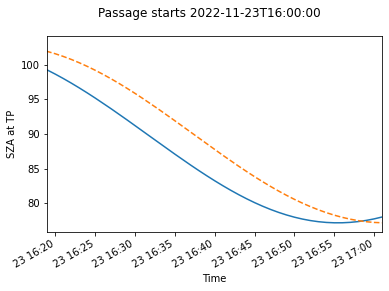

In [7]:

# fig,axs=plt.subplots(1,2,sharex=False,sharey=True)
# fig.suptitle("Passage starts {}".format(startdate.isoformat()))
# ax=axs[0]
# ax.plot(sublons,sublats,platslon,platslat,'+')
# ax.plot(sublons[0],sublats[0],'ro',platslon[0],platslat[0],'ro')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ax=axs[1]
# ax.plot(dateslist,platslat)
# ax.set_xlabel('Time')
# ax.set_ylabel('TP Latitude')

# fig.autofmt_xdate()
# fig,axs=plt.subplots(1,1,sharex=False,sharey=True)
# fig.suptitle("Passage starts {}".format(startdate.isoformat()))
# ax=axs
# ax.plot(platslat,szas)
# ax.plot(platslat[0],szas[0],'ro')
# ax.set_ylabel('SZA at TP')
# ax.set_xlabel('TP Latitude')

fig,axs=plt.subplots()
fig.autofmt_xdate()
fig.suptitle("Passage starts {}".format(startdate.isoformat()))
ax=axs
ax.plot(dateslist,szas)
ax.plot(dateslist,szan,'--')
ax.set_ylabel('SZA at TP')
ax.set_xlabel('Time')
ax.set_xlim(dateslist[18],dateslist[12*5])

In [8]:
I = np.where(np.logical_and(np.abs(np.array(szas)-100)<1,np.array(szan)>100))[0]
for i in I:
    print(str(dateslist[i]))

2022-11-23 16:16:00
2022-11-23 16:17:00
2022-11-23 16:18:00
2022-11-23 16:19:00
2022-11-23 17:53:00
2022-11-23 17:54:00
2022-11-23 17:55:00
2022-11-23 19:29:00
2022-11-23 19:30:00
2022-11-23 19:31:00
2022-11-23 19:32:00


In [9]:
I = np.where(np.abs(np.array(szas)-80)<1)[0]
for i in I:
    print(str(dateslist[i]))

2022-11-23 16:44:00
2022-11-23 16:45:00
2022-11-23 16:46:00
2022-11-23 16:47:00
2022-11-23 17:04:00
2022-11-23 17:05:00
2022-11-23 17:06:00
2022-11-23 17:07:00
2022-11-23 18:20:00
2022-11-23 18:21:00
2022-11-23 18:22:00
2022-11-23 18:23:00
2022-11-23 18:41:00
2022-11-23 18:42:00
2022-11-23 18:43:00
2022-11-23 18:44:00
2022-11-23 19:57:00
2022-11-23 19:58:00
2022-11-23 19:59:00
2022-11-23 20:00:00
